In [1]:
from util import d, here, tic, toc
from NSynthDataSet_RawAudio import NSynthDataSet_RawAudio
from transformers import GTransformer

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import RandomSampler

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

from argparse import ArgumentParser

import random, sys, math, gzip, os
from tqdm import tqdm
import copy

In [2]:
base_data_dir = '/home/purnima/appdir/Github/DATA/NSynth/'
train_data_dir = os.path.join(base_data_dir,'nsynth-train','audio')
test_data_dir = os.path.join(base_data_dir,'nsynth-test','audio')
validate_data_dir = os.path.join(base_data_dir,'nsynth-valid','audio')

labels_dir = '/home/purnima/appdir/Github/DATA/NSynth'
labels_file_name = 'examples.json'
# labels_file_name = 'examples-subset-full-acoustic-3000.json'

labels_train_dir = os.path.join(labels_dir,'nsynth-train', labels_file_name)
labels_test_dir = os.path.join(labels_dir,'nsynth-test', labels_file_name)
labels_validate_dir = os.path.join(labels_dir,'nsynth-valid', labels_file_name)

In [3]:
### Constants 

sample_rate = 16000

batch_size = 16
lr = 0.001
lr_warmup = 5000
epochs = 100

sample_length = 512 # For context
embedding_size = 128 
num_heads = 8 # Number of chunks for 'parallel/ensemble' computation
depth = 12 # Number of transformer layers
num_tokens = 256 #Size of the dictionary

### NSynth Dataset
Wav files for **guitar** instrument with pitch values from **40** to **88** are chosen. This selection leads to an initial dataset size of *15270* files. 

Each file can be sampled randomly 4 times between approximately 1 - 3 second timestamps to extract input and target of ***sample_length*** (currently 512) resulting in a total dataset size of ***15270 * 4 = 61080***

For each dataset.__getitem__ (one record of the dataset) if the input starts at 1 second time stamp (i.e. starting from 16000th sample) the target refers to samples starting from the 16001th sample. The samples are mu-law encoded and the results are shifted/adjusted to lie in between 0 to 255. 

Relevant constants:  
```
sample_rate = 16000  
batch_size = 16  
sample_length = 512 #(context)
```

In [ ]:
train_ds = NSynthDataSet_RawAudio(meta_data_file=labels_train_dir, audio_dir=train_data_dir, sr=sample_rate)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = NSynthDataSet_RawAudio(meta_data_file=labels_test_dir, audio_dir=test_data_dir, sr=sample_rate)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Validate dataset is not used at the moment.
# validate_ds = NSynthDataSet_RawAudio(meta_data_file=labels_validate_dir, audio_dir=validate_data_dir, sr=sample_rate)
# validate_loader = torch.utils.data.DataLoader(validate_ds, batch_size=batch_size, shuffle=False)

In [ ]:
def save_model(epoch, model, opt, loss, model_location):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': opt.state_dict(),
        'loss': loss,
        }, model_location) 
    print('Saved Model', flush=True)

### Define and Instantiate Transformer
  
Transformer architecture:  
1. 'Word' embedding layer (to convert each sample in audio to its embedding_size vector)
2. 'Position' embedding layer (to assign each sample a position - currently this is index of the sample in the array)
3. Sum of 'Word' and 'Position' embedding
4. Sequential Transformer Blocks `depth` layers in number.
5. Single Linear layer
6. Log softmax (We are using Negative Log Likelihood loss function which needs log probabilities)

Relevant constants (defined previously):   
```
sample_length = 512 #For context
embedding_size = 128 
num_heads = 8
depth = 12 #Number of transformer blocks in Sequential
num_tokens = 256 #Dictionary size. In our case levels from our companding. 
```

Our sequence is of length 512 samples. Output shapes from each layer --  
  
* Input to the model = `batch_size X sample_length` i.e. 16 X 512  
* Output from 'Word' embedding = `batch_size X sample_length X embedding_size` i.e. 16 X 512 X 128  
* Output from 'Position' embedding = `batch_size X sample_length X embedding_size` i.e. 16 X 512 X 128 (128 vector embedding for index position of each sample from 0 - 511)  
* Output from 'Word' + 'Position' embedding = `batch_size X sample_length X embedding_size` i.e. 16 X 512 X 128 (sum and not concat)  
* Output from Transformer Sequential Blocks = `batch_size X sample_length X embedding_size` i.e. 16 X 512 X 128  
* Output from Linear Layer (in preparation of the softmax layer) = `batch_size X sample_length X num_tokens` (or dictionary size) i.e. 16 X 512 X 256  
* Output from Log softmax = `batch_size X sample_length X num_tokens` i.e. 16 X 512 X 256  

In [ ]:
model = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=sample_length, num_tokens=num_tokens, attention_type=None)
model = model.cuda()

opt = torch.optim.Adam(lr=lr, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (lr_warmup / batch_size), 1.0))
loss = torch.nn.NLLLoss(reduction='mean')

## Training Loss Function

The NLL loss or Negative log likelihood accepts an input of log-probabilities of each 'class' (typically outputs from a log softmax function) of shape `batch_size X num_classes X input_dim` or in our case `batch_size X num_tokens X sample_length`   

See: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss

In [7]:
def train():
    training_loss = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        opt.zero_grad()
        data = data.cuda()
        target = target.cuda()

        output = model(data)
        running_loss = loss(output.transpose(2, 1), target)
        training_loss += running_loss.item()

        running_loss.backward() # backward pass
        
        gradient_clipping = 1.0
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

        opt.step() # stochastic gradient descent step
        sch.step() # update the learning rate
    
    training_loss /= len(train_loader)
    return training_loss

def test():
    model.eval()
    testing_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc='Testing')):

            data = data.cuda()
            target = target.cuda()

            output = model(data)

            running_loss = loss(output.transpose(2, 1), target)
            testing_loss += running_loss.item()

    # # To improve legibility only one loss norm is plotted for an epoch (Goodfellow - pg 276 diag 8.1)
    testing_loss /= len(test_loader)
    return testing_loss


Testing: 100%|██████████| 785/785 [00:33<00:00, 23.22it/s]


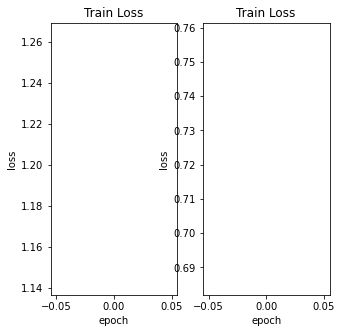

Saved Model


Testing: 100%|██████████| 785/785 [00:32<00:00, 24.14it/s]


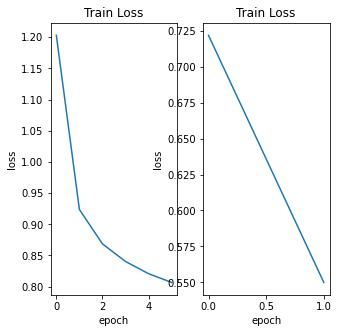

Saved Model


Testing: 100%|██████████| 785/785 [00:32<00:00, 24.16it/s]


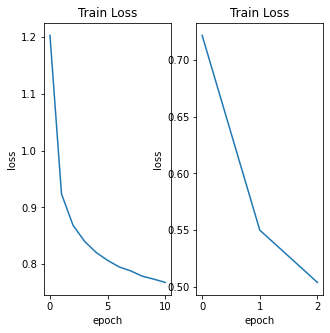

Saved Model


Testing: 100%|██████████| 785/785 [00:32<00:00, 24.15it/s]


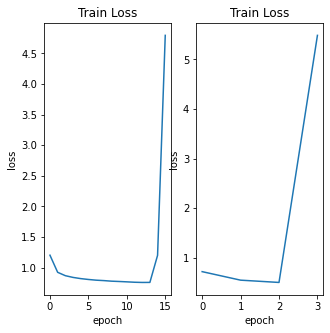

Saved Model


 19%|█▊        | 7971/42947 [17:49<1:18:11,  7.45it/s]


KeyboardInterrupt: 

In [8]:
history_train = {'loss': []}
history_test = {'loss': []}

for epoch in range(epochs):
    train_loss = train()
    history_train['loss'].append(train_loss)
    
    if epoch%5 == 0 or epoch == epochs:
        test_loss = test()
        history_test['loss'].append(test_loss)
        
        fig, axes = plt.subplots(ncols=2, figsize=(5, 5))
        axes[0].plot(history_train['loss'])
        axes[0].set_title('Train Loss')
        axes[0].set_xlabel('epoch')
        axes[0].set_ylabel('loss')
        
        axes[1].plot(history_test['loss'])
        axes[1].set_title('Train Loss')
        axes[1].set_xlabel('epoch')
        axes[1].set_ylabel('loss')
        plt.show()

        save_model(epoch, model, opt, loss, f'checkpoint/attention-{epoch}.pt')